In [33]:
from project.dataset_acquisition import init_dataset_service
from project.data_preparation import dataloader_service
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_built() else "cpu")
print(f"Device: {device}")

IMAGE_SIZE = 128
LATENT_DIM = 100
image_dim = IMAGE_SIZE * IMAGE_SIZE * 3

train_loader, val_loader, test_loader = dataloader_service.get_dataloader(
  dataset_name="Flowers",
  batch_size=batch_size,
  shuffle=True,
  device=device
)

# Megnézzük az első batch-t mindegyik DataLoader-ből
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))
test_batch = next(iter(test_loader))

images, labels = train_batch
x = images

Device: mps


torch.Size([3, 128, 128])


Text(0.5, 1.0, 'Típus: 0')

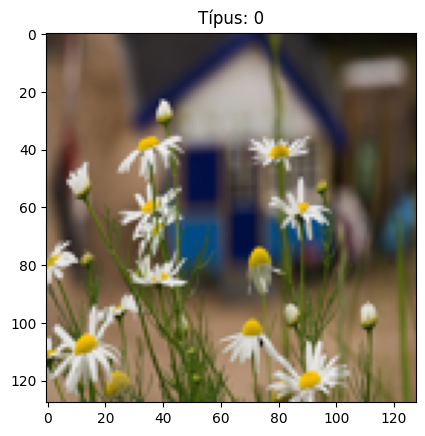

In [34]:
idx = np.random.choice(len(images))
print(images[idx].to("cpu").shape)
plt.imshow(images[idx].permute(1,2,0).to("cpu"), cmap='gray')
plt.title("Típus: " + str(labels[idx].item()))

In [41]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    
    hidden_dims = [32, 64, 128, 256, 512]
    self.final_dim = hidden_dims[-1]
    in_channels = 3
    modules = []

    # Encoder
    for dim in hidden_dims:
      modules.append(
        nn.Sequential(
          nn.Conv2d(in_channels, out_channels=dim, kernel_size=3, stride=2, padding=1),
          nn.BatchNorm2d(dim),
          nn.LeakyReLU()
        )
      )
      in_channels = dim

    self.encoder = nn.Sequential(*modules)
    out = self.encoder(torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE))
    self.size = out.shape[2]
    self.fc_mu = nn.Linear(hidden_dims[-1] * self.size * self.size, LATENT_DIM)
    self.fc_logvar = nn.Linear(hidden_dims[-1] * self.size * self.size, LATENT_DIM)

    # Decoder
    modules = []
    self.decoder_input = nn.Linear(LATENT_DIM, hidden_dims[-1] * self.size * self.size)
    hidden_dims.reverse()

    for i in range(len(hidden_dims) - 1):
      modules.append(
        nn.Sequential(
          nn.ConvTranspose2d(hidden_dims[i],
                              hidden_dims[i + 1],
                              kernel_size=3,
                              stride=2,
                              padding=1,
                              output_padding=1),
          nn.BatchNorm2d(hidden_dims[i + 1]),
          nn.LeakyReLU())
      )

    self.decoder = nn.Sequential(*modules)

    self.final_layer = nn.Sequential(
      nn.ConvTranspose2d(hidden_dims[-1],
                          hidden_dims[-1],
                          kernel_size=3,
                          stride=2,
                          padding=1,
                          output_padding=1),
      nn.BatchNorm2d(hidden_dims[-1]),
      nn.LeakyReLU(),
      nn.Conv2d(hidden_dims[-1], out_channels=3,
                kernel_size=3, padding=1),
      nn.Sigmoid())
    
  def encode(self, x):
    result = self.encoder(x)
    result = torch.flatten(result, start_dim=1)
    mu = self.fc_mu(result)
    log_var = self.fc_logvar(result)
    return mu, log_var

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return eps * std + mu

  def decode(self, z):
    result = self.decoder_input(z)
    result = result.view(-1, self.final_dim, self.size, self.size)
    result = self.decoder(result)
    result = self.final_layer(result)
    return result

  def forward(self, x):
    mu, log_var = self.encode(x)
    z = self.reparameterize(mu, log_var)
    return self.decode(z), mu, log_var

torch.Size([5, 3, 128, 128])


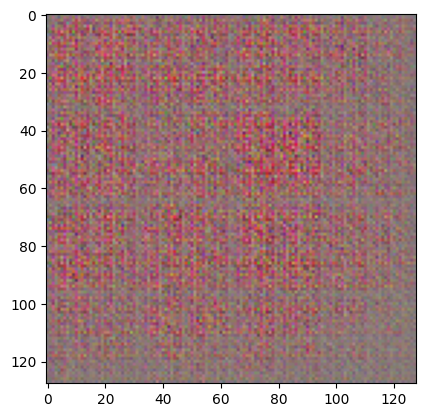

In [44]:
vae = VAE().to(device)
with torch.no_grad():
  print(vae(x[:5])[0].shape)
  plt.imshow(vae(x[:5])[0][0].to("cpu").permute(1,2,0).numpy())

In [45]:
model = VAE().to(device)

model.train()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

num_epoch = 10
for epoch in range(num_epoch):
  for i,(x_batch,_) in enumerate(train_loader):
    print(f"Epoch: {epoch}, Batch: {i}")
    x_batch_gpu = x_batch.to(device)
    x_rec, mu, lv = model(x_batch_gpu)
    kl = torch.sum(0.5 * (mu**2 + (torch.exp(lv)) - 1 - lv))
    loss = torch.sum((x_batch_gpu - x_rec)**2) + kl
    opt.zero_grad()
    loss.backward()
    opt.step()

Epoch: 0, Batch: 0
Epoch: 0, Batch: 1
Epoch: 0, Batch: 2
Epoch: 0, Batch: 3
Epoch: 0, Batch: 4
Epoch: 0, Batch: 5
Epoch: 0, Batch: 6
Epoch: 0, Batch: 7
Epoch: 0, Batch: 8
Epoch: 0, Batch: 9
Epoch: 0, Batch: 10
Epoch: 0, Batch: 11
Epoch: 0, Batch: 12
Epoch: 0, Batch: 13
Epoch: 0, Batch: 14
Epoch: 0, Batch: 15
Epoch: 0, Batch: 16
Epoch: 0, Batch: 17
Epoch: 0, Batch: 18
Epoch: 0, Batch: 19
Epoch: 0, Batch: 20
Epoch: 0, Batch: 21
Epoch: 0, Batch: 22
Epoch: 0, Batch: 23
Epoch: 0, Batch: 24
Epoch: 0, Batch: 25
Epoch: 0, Batch: 26
Epoch: 0, Batch: 27
Epoch: 0, Batch: 28
Epoch: 0, Batch: 29
Epoch: 0, Batch: 30
Epoch: 0, Batch: 31
Epoch: 0, Batch: 32
Epoch: 0, Batch: 33
Epoch: 0, Batch: 34
Epoch: 0, Batch: 35
Epoch: 0, Batch: 36
Epoch: 0, Batch: 37
Epoch: 0, Batch: 38
Epoch: 0, Batch: 39
Epoch: 0, Batch: 40
Epoch: 0, Batch: 41
Epoch: 0, Batch: 42
Epoch: 0, Batch: 43
Epoch: 0, Batch: 44
Epoch: 0, Batch: 45
Epoch: 0, Batch: 46
Epoch: 0, Batch: 47
Epoch: 0, Batch: 48
Epoch: 0, Batch: 49
Epoch: 0, 

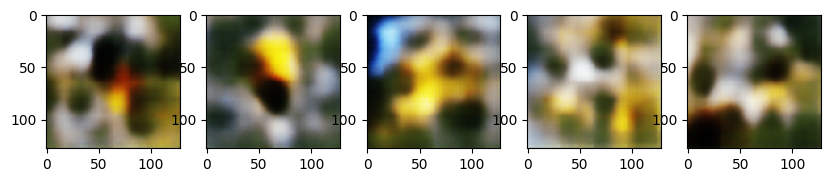

In [52]:
with torch.no_grad():
  out = model.decode(torch.randn(5,100).to(device))

f, ax = plt.subplots(1,5,figsize=(10,3))
for i in range(5):
  ax[i].imshow(out[i].cpu().permute(1,2,0), cmap='gray')